In [16]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [17]:
def read_data():
    with open('../rnn/the_time_machine.txt', 'r') as txt:
        lines = txt.readlines()
    import re
    return [
        l for l in
        [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
        if l.strip() != ''
    ]
def tokenize(data):
    return [ch for line in data for ch in list(line)]
class Vocab:
    
    def __init__(self, tokens) -> None:
        import collections
        counter = collections.Counter(tokens)
        tokens = [ k for k, _ in sorted(counter.items(), key=lambda item: item[1], reverse=True) ]
        tokens.insert(0, '<unk>')
        self.tokens_indicates = { token: idx for idx, token in enumerate(tokens)}
        self.indicates_tokens = { v: k for k, v in self.tokens_indicates.items()}
    
    @property
    def unk(self):
        return 0
    
    def __len__(self):
        return len(self.tokens_indicates)
    
    def __getitem__(self, keys):
        if isinstance(keys, str):
            return self.tokens_indicates[keys]
        if isinstance(keys, list):
            return [self.__getitem__(key) for key in keys]
        if isinstance(keys, (torch.Tensor)):
            keys = keys.reshape(-1)
            return ''.join(self.indicates_tokens[int(keys[i])] for i in range(keys.numel()))
        return self.indicates_tokens[keys]
def build_data(tokens):
    vocab = Vocab(tokens=tokens)
    corpus = [vocab[t] for t in tokens]
    return corpus, vocab

def dataloader(steps, batch_size=2):    
    import random
    corpus, vocab = build_data(tokenize(read_data()))
    _len = len(corpus)
    def _train_iter():
        _discard = random.randint(0, _len - 1)
        _corpus = corpus[_discard:]
        m = (_len - _discard) // steps
        coll = []
        indicates = list(range(m))
        random.shuffle(indicates)
        batch_x, batch_y = [], []
        for i in indicates:
            start = i * steps
            end = (i + 1) * steps
            x = _corpus[start:end]
            y = _corpus[start+1:end+1]
            if len(x) == steps and len(y) == steps:
                batch_x.append(x)
                batch_y.append(y)
            if len(batch_x) == batch_size:
                yield torch.tensor(batch_x, dtype=torch.int64), torch.tensor(batch_y, dtype=torch.int64)
                batch_x, batch_y = [], []
    while True:
        yield _train_iter(), vocab

In [18]:
class GRU(nn.Module):
    
    def __init__(self, n_input, n_output, std, **kwargs) -> None:
        super(**kwargs).__init__()
        # parameters of candidate `hidden state` of time step T
        self.w_xh = nn.Parameter(torch.randn(n_input, n_output) * std)
        self.w_hh = nn.Parameter(torch.randn(n_output, n_output) * std)
        self.b_h = nn.Parameter(torch.zeros(size=(n_output,)))
        
        # parameters of reset gate
        self.w_xr = nn.Parameter(torch.randn(n_input, n_output) * std)
        self.w_hr = nn.Parameter(torch.randn(n_output, n_output) * std)
        self.b_r = nn.Parameter(torch.zeros(size=(n_output,)))
        
        # parameters of update gate
        self.w_xz = nn.Parameter(torch.randn(n_input, n_output) * std)
        self.w_hz = nn.Parameter(torch.randn(n_output, n_output) * std)
        self.b_z = nn.Parameter(torch.zeros(size=(n_output,)))
        
    def forward(self, x, state=None):
        outputs = []
        for step in x:
            # through the `step` dimension for updating state
            # calculate reset gate
            reset_gate = torch.sigmoid((step @ self.w_xr) + (0. if state is None else state @ self.w_hr) + self.b_r)
            # calculate update gate
            update_gate = torch.sigmoid((step @ self.w_xz) + (0. if state is None else state @ self.w_hz) + self.b_z)
            # candidate state
            candidate = torch.tanh((step @ self.w_xh) + (0. if state is None else (reset_gate * state) @ self.w_hh) + self.b_h)
            # determinate current hidden state
            state = (update_gate * (0. if state is None else state)) + ((1. - update_gate) * candidate)
            outputs.append(state)
        return outputs, state

class MultiLayerGRU(nn.Module):
    
    def __init__(self, vocab_size, hiddens, std=1e-2, **kwargs) -> None:
        super(**kwargs).__init__()
        hiddens = [vocab_size] + hiddens
        self.grus = []
        self.hiddens = hiddens
        self.vocab_size = vocab_size
        for i in range(len(hiddens) - 1):
            self.grus.append(GRU(hiddens[i], hiddens[i + 1], std))
        self.fc = nn.Linear(hiddens[-1], vocab_size)
    
    def forward(self, x, state=None):
        # x.T.shape = (step, batch_size)
        if len(x.shape) < 2:
            x = x.unsqueeze(1)
        x = torch.nn.functional.one_hot(x.T, self.vocab_size).to(dtype=torch.float32)
        # (batch_size, step, input) to (step, batch_size, input)
        # x = x.permute((1, 0, 2))
        if state is None: state = [None] * len(self.hiddens)
        for i, gru in enumerate(self.grus):
            x, state[i] = gru(x, state[i])
        outputs = [self.fc(output) for output in x]
        return torch.stack(outputs, dim=1), state

In [19]:
def grad_clip(net: nn.Module, clip_val=1):
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > clip_val:
        for parm in params:
            parm.grad[:] *= clip_val / norm

epoch: [100/100


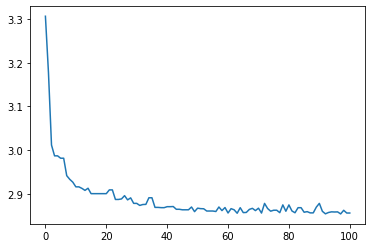

In [24]:
# training the rnn model
dl = dataloader(32, batch_size=1024)
_, vocab = next(dl)
net = MultiLayerGRU(vocab_size=len(vocab), hiddens=[32,32])
epochs = 100
optimizer = torch.optim.SGD(net.parameters(), lr=2)
loss_fn = torch.nn.CrossEntropyLoss()
net.zero_grad()
losses = []
for epoch in range(0, epochs + 1):
    train_iter, _ = next(dl)
    for x, y in train_iter:
        optimizer.zero_grad()
        # 1024 32 28
        y_hat, _ = net(x)
        y_hat = y_hat.permute((0, 2, 1))
        # y_hat = torch.reshape(y_hat, (-1, y_hat.shape[-1]))
        # y = torch.nn.functional.one_hot(y, net.vocab_size).to(dtype=torch.float32)
        loss = loss_fn(y_hat, y)
        with torch.no_grad():
            loss.backward()
            grad_clip(net)
            optimizer.step()
    print(f"\repoch: [{epoch}/{epochs}", end='')
    losses.append(loss.detach().numpy())
    # print(f'loss: {loss: .6f}')
print()
plt.plot(losses)

In [26]:
def predict(input, num_preds, vocab, net):
    # warmup
    state = None
    output = []
    softmax = torch.nn.LogSoftmax(dim=2)
    for ch in input:
        x = torch.tensor([vocab[ch]])
        # x = x.reshape((1,1,1))
        _, state = net(x, state)
        output.append(x)
    for i in range(num_preds):
        x = output[-1]
        # x = x.reshape((1,1,1))
        y_hat, state = net(x, state)
        y_hat = softmax(y_hat)
        y_hat = torch.argmax(y_hat, dim=2)
        output.append(y_hat.detach())
    return ''.join(vocab[output])
predict("it has", 100, vocab, net)

'it has                                                                                                    '